In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
df_randomE = pd.read_csv('original_data_files/E_global_v46.csv', index_col=0)

In [3]:
species_randomE_dict = {}

# 遍历 DataFrame 的每一行
for microbe_name, row_data in df_randomE.iterrows():
    # 将该行的所有资源消耗值转换成一个列表 (向量)
    # row_data 是一个 Pandas Series，.values 会将其转换为 NumPy 数组，.tolist() 转换为列表
    resource_vector = row_data.tolist()
    species_randomE_dict[microbe_name] = resource_vector

In [4]:
def load_pretrained_embeddings(vectors_file):
    with open(vectors_file, 'r') as f:
        vectors = {}
        for line in f:
            vals = line.rstrip().split(' ')
            if vals[0] != '<unk>':
                vectors[vals[0]] = [float(x) for x in vals[1:]]
    return vectors

In [5]:
def get_upper_triangle_values(df):
    """高效获取矩阵上三角值"""
    matrix = df.values
    return matrix[np.triu_indices_from(matrix, k=1)]


In [6]:
df_sim_randomE = pd.DataFrame(cosine_similarity(np.array([species_randomE_dict[key] for key in species_randomE_dict.keys()])), index=species_randomE_dict.keys(), columns=species_randomE_dict.keys())

## 加载embedding数据

In [10]:
from skbio.stats.distance import mantel
corr_list = []
metrics = ['abundance_percentile', 'abundance_totalsum', 'braycurtis_percentile', 'braycurtis_totalsum', 'faith', 'jaccard', 'russell_rao', 'russell_rao_weight']
for metric in metrics:
    current_list = list()
    for i in range(1, 6):
        embedding_path_template = f'metrics_embeddings/embeddings_{metric}_rep{i}.txt'
        embedding_dict = load_pretrained_embeddings(embedding_path_template)
        df_sim_embedding = pd.DataFrame(cosine_similarity(np.array([embedding_dict[key] for key in species_randomE_dict.keys()])), index=species_randomE_dict.keys(), columns=species_randomE_dict.keys())
        array_sim_randomE = df_sim_randomE.to_numpy()
        np.fill_diagonal(array_sim_randomE, 0)
        array_sim_embedding = df_sim_embedding.to_numpy()
        np.fill_diagonal(array_sim_embedding, 0)
        r, p_value, n = mantel(array_sim_randomE, array_sim_embedding, method='pearson', permutations=999)
        current_list.append(abs(r))
    corr_list.append(current_list)

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def plot_correlation_comparison(metrics, corr_list, error_bar_type='std'):
    """
    绘制带有误差线的条形图，比较不同方法的平均相关性值。
    方法会根据平均相关性值进行降序排序。

    参数:
    metrics (list): 包含方法名称的列表 (字符串)。
    corr_list (list of lists): 包含每个方法多次相关性值的列表。
                               每个子列表对应 metrics 中的一个方法。
    error_bar_type (str): 误差线的类型，可以是 'std' (标准差) 或 'sem' (标准误差)。
                          默认为 'std'。
    """

    # 计算每个方法的平均相关性和误差
    means = [np.mean(corrs) for corrs in corr_list]
    
    if error_bar_type == 'std':
        errors = [np.std(corrs) for corrs in corr_list]
    elif error_bar_type == 'sem':
        errors = [np.std(corrs) / np.sqrt(len(corrs)) for corrs in corr_list]
    else:
        raise ValueError("error_bar_type must be 'std' or 'sem'")

    # 将方法名称、平均值和误差组合起来，以便排序
    combined_data = sorted(zip(metrics, means, errors), key=lambda x: x[1], reverse=True)

    # 解包排序后的数据
    sorted_metrics = [data[0] for data in combined_data]
    sorted_means = [data[1] for data in combined_data]
    sorted_errors = [data[2] for data in combined_data]

    fig, ax = plt.subplots(figsize=(4, 4)) # 调整图像大小以便更好地显示标签

    # 创建条形图
    bars = ax.bar(sorted_metrics, sorted_means, yerr=sorted_errors, 
                  capsize=5, color='skyblue', ecolor='gray', alpha=0.8)

    # 添加标题和标签
    # ax.set_title('不同方法的平均相关性比较 (按性能排序)', fontsize=16)
    # ax.set_xlabel('Metrics', fontsize=14)
    ax.set_ylabel(f'R', fontsize=14)
    
    # 旋转 x 轴标签以防止重叠
    plt.xticks(rotation=45, ha="right", fontsize=10) # ha="right" 使标签右对齐，更美观
    plt.yticks(fontsize=10)

    # 在每个条形上方显示平均值
    for bar in bars:
        yval = bar.get_height()
        # 根据值的正负调整文本位置
        text_y_offset = 0.01 if yval >= 0 else -0.03 
        # 格式化数值，保留2位小数
        ax.text(bar.get_x() + bar.get_width()/2.0, yval + text_y_offset, 
                f'{yval:.2f}', 
                ha='center', va='bottom' if yval >=0 else 'top', 
                fontsize=9)

    # 添加网格线，使其更易读
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    # 自动调整Y轴范围以更好地显示数据
    if sorted_means: # 如果有有效数据点
        min_val = min(m - s for m, s in zip(sorted_means, sorted_errors) if not (np.isnan(m) or np.isnan(s)))
        max_val = max(m + s for m, s in zip(sorted_means, sorted_errors) if not (np.isnan(m) or np.isnan(s)))
        if not (np.isnan(min_val) or np.isnan(max_val)):
            padding = (max_val - min_val) * 0.1 # 上下留10%的边距
            ax.set_ylim(min_val - padding, max_val + padding)
    # 调整布局以适应旋转的标签
    plt.tight_layout()

    # 显示图表
    plt.show()

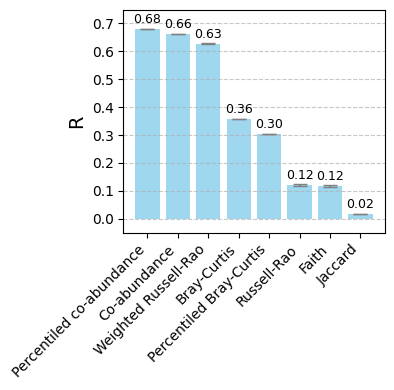

In [12]:
plot_correlation_comparison(['Percentiled co-abundance', 'Co-abundance', 'Percentiled Bray-Curtis', 'Bray-Curtis', 'Faith', 'Jaccard', 'Russell-Rao', 'Weighted Russell-Rao'], corr_list, error_bar_type='std')